In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py
import os

In [3]:
Tr=  1.9
dats1 = pd.read_csv("/Volumes/ThermalAmp/DataSeries/Tr1.0.csv")
dats2k = pd.read_csv("/Volumes/ThermalAmp/DataSeries/Tr1-ALL.csv")

In [ ]:
dats2k

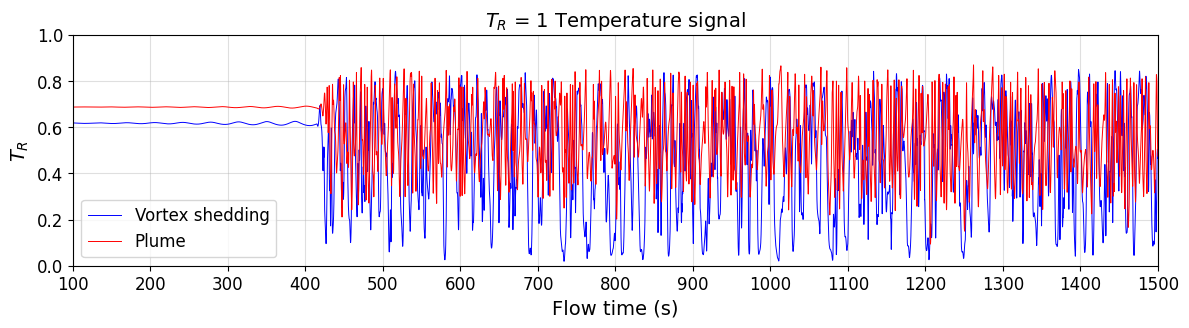

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
dats = "/Volumes/ThermalAmp/DataSeries/Tr{}.csv".format("1.0")

dat_pd = pd.read_csv(dats)

plumeT = dat_pd['plumeT'].to_numpy()
vortT = dat_pd['vortT'].to_numpy()
flowt = dat_pd['flowt'].to_numpy()

ax.plot(np.concatenate((dats2k['flowt'].to_numpy(), flowt)), (np.concatenate((dats2k['vortT'].to_numpy(), vortT))-298)/(308-298), label="Vortex shedding",  color='b', lw=0.7)

ax.plot(np.concatenate((dats2k['flowt'].to_numpy(), flowt)), (np.concatenate((dats2k['plumeT'].to_numpy(), plumeT))-298)/(308-298), label="Plume", color='r', lw=0.7)

ax.set_xlim([100,1500])
ax.set_ylim([0,1])
x_ticks = np.arange(100,1501,100)
ax.set_xticks(x_ticks)
ax.grid(alpha=0.4)
ax.set_ylabel("$T_R$", fontsize=14)
#ax.set_xticklabels([100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500])

plt.tick_params(axis='both', which='major', labelsize=12) 
ax.set_xlabel("Flow time (s)", fontsize=14)
ax.set_title("$T_R$ = 1 Temperature signal", fontsize=14)
ax.legend(fontsize=12, loc='lower left')

plt.savefig("/Volumes/ThermalAmp/PLOTS/Tr1-signal.pdf", dpi=500, bbox_inches='tight')

In [123]:

# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]


# Read the mesh data from the HDF5 file
with h5py.File("/Volumes/ThermalAmp/Tr1/M4-2002.cas.post", 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]

with h5py.File(fdd, 'r') as f:
    T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]

from scipy.interpolate import griddata
SI = griddata((node_x, node_y), T, (xgrid, ygrid), method='nearest', fill_value=np.nan)

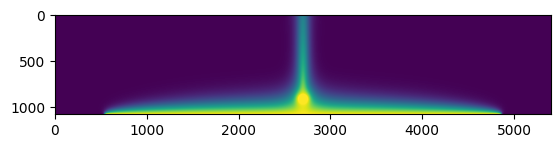

In [124]:
plt.imshow(SI)

In [132]:
def query_point(node_x, node_y, data_file, z1, z2, z3, query_x, query_y):
    """Given a set of cell coordinates node_x, node_y, and a list of requested coordinates query_x, query_y,
    obtain the corresponding z values from the entire z array.
    """
    # Convert lists to numpy arrays if they are not already
    query_x = np.array(query_x)
    query_y = np.array(query_y)

    with h5py.File(data_file, "r") as f:
        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

    
    # Initialize lists to store results
    results = []
    
    # Tolerances - found with trial and error. 
    tolerance = 1e-4
    rtol = 1e-2
    
    for x, y in zip(query_x, query_y):
        queried_indices = np.where(
            np.isclose(node_x, x, atol=tolerance, rtol=rtol) &
            np.isclose(node_y, y, atol=tolerance, rtol=rtol)
        )
        
        # This will likely return multiple values - this is the result of the 
        # first combination of tolerances that returns nonzero close values.
        # It is assumed that they are close enough in value so that we 
        # can take the average of the values corresponding to the found indices
        close_x = np.nanmean(node_x[queried_indices])
        close_y = np.nanmean(node_y[queried_indices])
        close_z1 = np.nanmean(z1[queried_indices])
        
        #results.append((queried_indices, close_x, close_y, close_z1, close_z2, close_z3, timestep, flowtime))
        results.append((close_z1, timestep, flowtime))
    
    return results

query_x = [0.1, 0.005]
query_y = [-0.01, 0.01]

# Test for 1 data file
query_point(node_x, node_y, fdd, T, _, _, query_x, query_y)

def get_query_point_from_datafile(node_x, node_y, data_file, query_x, query_y):
    
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]

    results = query_point(node_x, node_y, data_file, T, _,_, query_x, query_y)

    return results



/Volumes/ThermalAmp/Tr1/M4-2002.dat.post
env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3999 out of 3999 | elapsed:  3.4min finished


In [ ]:
data_folder = "/Volumes/ThermalAmp/Tr1/"
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
data_files = [f for f in data_files if "/._" not in f]

def get_time(data_file):
    try:
        return float(data_file.split(".")[0].split("-")[-1])  #My directories
        #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
    except:
        return float(data_file.split(".")[1].split("-")[-1])

data_files = sorted(data_files, key=get_time)

print(data_files[0])
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning

if "10000.dat.post" in data_files[3999]:
    dats = data_files[3999:-1001]
else:
    dats = data_files[0:10000]
    
# Use LokyBackend to protect the h5py routine
timeseries_results = Parallel(n_jobs=-1, backend='threading', verbose=1) \
(delayed(get_query_point_from_datafile) \
 (node_x, node_y, data_file, query_x, query_y
 ) for data_file in dats)
timeseries_results_array = np.array(timeseries_results, dtype=object)

dat_out = np.column_stack(
    (
        timeseries_results_array[:,:,0], #plumeT
        timeseries_results_array[:,:,1][:,0], #timesteps
        timeseries_results_array[:,:,2][:,0], #flowtimes
    )
)
datt = pd.DataFrame(dat_out, columns=["plumeT", "vortT", "plumetstep", "flowt"])
datt.to_csv("/Volumes/ThermalAmp/DataSeries/Tr1-ALL.csv".format(Tr))


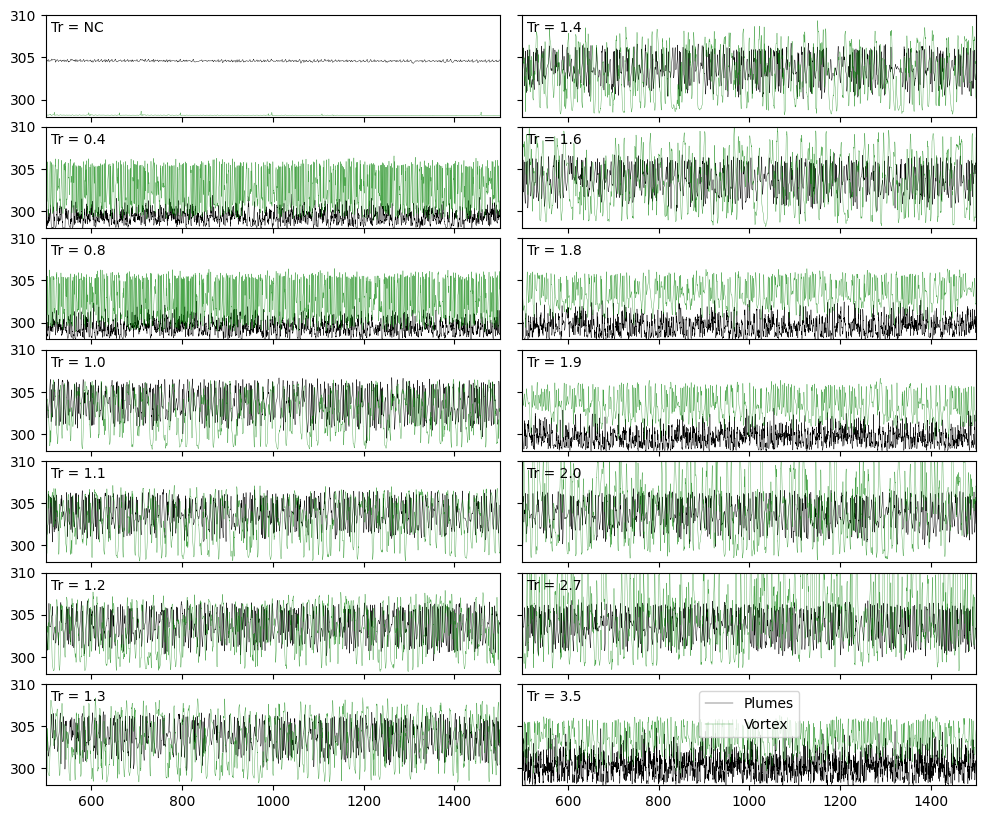

In [102]:
fig, axes = plt.subplots(7, 2, figsize=(12, 10))
#axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.1, wspace=0.05)  # Adjust space between plots

#dcases = ["NC", 0.4, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.7, 3.5]

dcases = ["NC", 0.4, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 1.9, 2.0, 2.7, 3.5]
nrows, ncols = 7, 2
reordered_axes = [axes[r, c] for c in range(ncols) for r in range(nrows)]

yposs = np.arange(0.005, -0.1, -0.05)
for i, ax in enumerate(reordered_axes):
    
    dats = "/Volumes/ThermalAmp/DataSeries/Tr{}.csv".format(dcases[i])
    
    dat_pd = pd.read_csv(dats)
    
    plumeT = dat_pd['plumeT'].to_numpy()
    vortT = dat_pd['vortT'].to_numpy()
    flowt = dat_pd['flowt'].to_numpy()
    
    ax.plot(flowt, plumeT, label="Plumes", color='k', lw=0.3)
    ax.plot(flowt, vortT, label="Vortex", color='g', alpha=0.7, lw=0.3)
    
    ax.text(510, 308, "Tr = {}".format(dcases[i]), color='k',)

    ax.set_xlim([500,1500])
    ax.set_ylim([298,310])

    if i not in [6, 13]:
        ax.set_xticklabels([])

    if i > 6:
        ax.set_yticklabels([])
ax.legend()

In [104]:
def get_autocorrelation(z):
    # Compute the autocorrelation
    autocorr = np.correlate(z - np.mean(z), z - np.mean(z), mode='full')
    # Take only the 2nd half to get rid of negative lags
    autocorr = autocorr[autocorr.size // 2:]
    autocorr /= autocorr[0]
    return autocorr


dcases = ["NC", 0.4, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.7, 3.5]


for cas in dcases:
    dats = "/Volumes/ThermalAmp/DataSeries/Tr{}.csv".format(cas)
    
    dat_pd = pd.read_csv(dats)
    
    plumeT = dat_pd['plumeT'].to_numpy()
    vortT = dat_pd['vortT'].to_numpy()
    flowt = dat_pd['flowt'].to_numpy()
    
    vortex_autocorr = get_autocorrelation(vortT)
    plume_autocorr = get_autocorrelation(plumeT)

    pd.DataFrame(np.column_stack((vortex_autocorr, plume_autocorr)), columns=["autoV", "autoP"]).to_csv("/Volumes/ThermalAmp/DataSeries/Auto-Tr{}.csv".format(cas))
    


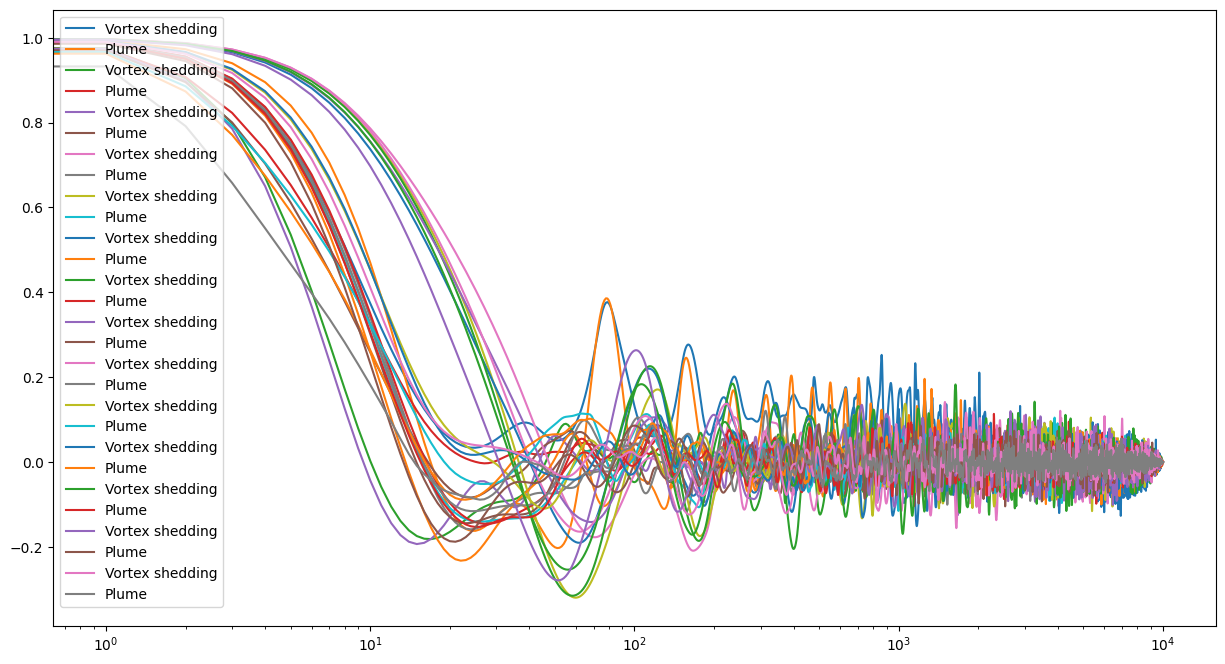

In [111]:
v_timescale = []
p_timescale = []

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
dcases = ["NC", 0.4, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 1.9, 2.0, 2.7, 3.5]

for cas in dcases:
    autos = "/Volumes/ThermalAmp/DataSeries/Auto-Tr{}.csv".format(cas)
    
    autos_pd = pd.read_csv(autos)
    v_timescale.append(np.where(np.diff(np.sign(autos_pd['autoV'])))[0][0]*0.05)
    p_timescale.append(np.where(np.diff(np.sign(autos_pd['autoP'])))[0][0]*0.05)
    
    ax.semilogx(autos_pd['autoV'], label="Vortex shedding")
    ax.semilogx(autos_pd['autoP'], label="Plume")
    
ax.legend()


(0.0, 10.0)

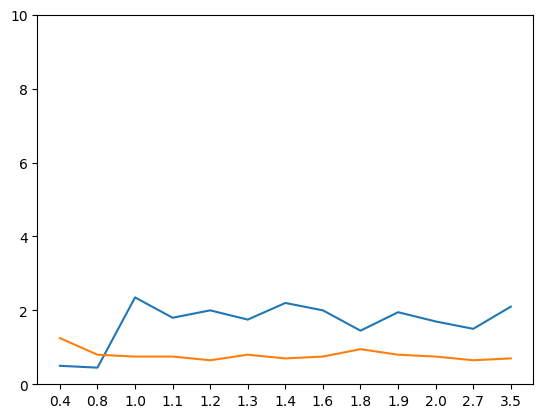

In [113]:
plt.plot([str(c) for c in dcases[1:]], v_timescale[1:])
plt.plot([str(c) for c in dcases[1:]], p_timescale[1:])
plt.ylim([0,10])